# Trying to explain 'lensing is too low' through baryonic effects 

using baryonification model to match lensing in measurements

[Saito et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.460.1457S/abstract) 

[Reid et al. 2014](https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..476R/abstract) (for wp)

Lange et al. 2019 and Wibking et al. 2019 discuss 'lensing is low'

1) Use halo tools to generate an HOD and plot a CMASS like wp and DS

2) Apply the displacement model and redo wp and DS with the same HOD. How are the two plots different?

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from astropy.io import ascii

from halotools.sim_manager import UserSuppliedHaloCatalog, UserSuppliedPtclCatalog
from halotools.mock_observables import delta_sigma, wp
from halotools.utils import add_halo_hostid
#Length units are comoving and assumed to be in Mpc/h, here and throughout Halotools

from astropy.cosmology import Planck15

## CMASS data 

In [2]:
data_dir = '/Users/fardila/Documents/GitHub/baryonic_effects/CMASS/data/'

wp_data_file = 'wpNSdebiasedboss5003.txt'
wp_correct_cosmology_data_file = 'wp_cmass_z0.430.70'

ds_data_file = 'cmass_deltasigma_0.43_0.7.txt'

In [3]:
wp_data = ascii.read(data_dir+wp_data_file, names = ['rp','wp','wp_err'])
wp_correct_cosmology_data = ascii.read(data_dir+wp_correct_cosmology_data_file, names = ['rp','wp','wp_err'])

ds_data = ascii.read(data_dir+ds_data_file, names = ['rp','ds','ds_err'])

## simulation: MDPL2 

### load catalogs 

In [4]:
data_directory = '/Users/fardila/Documents/Data/baryonic_effects/CMASS/'
queried_halo_cat_file = 'halo_catalogs/mdpl2_hlist_0.65650_Mvir11.2.csv'
### "row_id","Mvir","Rvir","M200c","M500c","x","y","z","scale"
full_halo_cat_file = 'halo_catalogs/cut_halo_df.pkl'
particle_cat_file = 'particle_catalogs/mdpl2_particles_0.6565_10m.dat'
### "x","y","z"


In [5]:
header = 'scale(0) id(1) desc_scale(2) desc_id(3) num_prog(4) pid(5) upid(6) desc_pid(7) phantom(8) sam_mvir(9) mvir(10) rvir(11) rs(12) vrms(13) mmp?(14) scale_of_last_MM(15) vmax(16) x(17) y(18) z(19) vx(20) vy(21) vz(22) Jx(23) Jy(24) Jz(25) Spin(26) Breadth_first_ID(27) Depth_first_ID(28) Tree_root_ID(29) Orig_halo_ID(30) Snap_num(31) Next_coprogenitor_depthfirst_ID(32) Last_progenitor_depthfirst_ID(33) Last_mainleaf_depthfirst_ID(34) Tidal_Force(35) Tidal_ID(36) Rs_Klypin(37) Mmvir_all(38) M200b(39) M200c(40) M500c(41) M2500c(42) Xoff(43) Voff(44) Spin_Bullock(45) b_to_a(46) c_to_a(47) A[x](48) A[y](49) A[z](50) b_to_a(500c)(51) c_to_a(500c)(52) A[x](500c)(53) A[y](500c)(54) A[z](500c)(55) T/|U|(56) M_pe_Behroozi(57) M_pe_Diemer(58) Macc(59) Mpeak(60) Vacc(61) Vpeak(62) Halfmass_Scale(63) Acc_Rate_Inst(64) Acc_Rate_100Myr(65) Acc_Rate_1*Tdyn(66) Acc_Rate_2*Tdyn(67) Acc_Rate_Mpeak(68) Mpeak_Scale(69) Acc_Scale(70) First_Acc_Scale(71) First_Acc_Mvir(72) First_Acc_Vmax(73) Vmax\@Mpeak(74) Tidal_Force_Tdyn(75) Log_(Vmax/Vmax_max(Tdyn;Tmpeak))(76) Time_to_future_merger(77) Future_merger_MMP_ID(78)'

In [6]:
# full_halo_df = pd.read_csv(full_halo_cat_file,header=None, delimiter = '\s+', skiprows=63, names=header.split(' '))

In [7]:
# halo_df = pd.read_csv(data_directory+queried_halo_cat_file)
full_halo_df = pd.read_pickle(data_directory+full_halo_cat_file)
particles_df = pd.read_csv(data_directory+particle_cat_file, delimiter ='     ', names=['x','y','z'])

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
ptcl_x = particles_df['x'].values
ptcl_y = particles_df['y'].values
ptcl_z = particles_df['z'].values

In [9]:
redshift = (1./0.65650)-1. #z=0.523
Lbox = 1000. #Mpc/h
particle_mass = 1.51e9
num_ptcl_per_dim = 3840
x = full_halo_df['x(17)'].values
y = full_halo_df['y(18)'].values
z = full_halo_df['z(19)'].values
vx = full_halo_df['vx(20)'].values
vy = full_halo_df['vy(21)'].values
vz = full_halo_df['vz(22)'].values
mass = full_halo_df['mvir(10)'].values
radius = full_halo_df['rvir(11)'].values/1e3 #convert to Mpc
ids = np.arange(0, len(full_halo_df))
upid = full_halo_df['upid(6)'].values
simname = 'MDPL2'


In [10]:
#get concentrations
from halotools.empirical_models import NFWProfile

nfw = NFWProfile(redshift=redshift, mdef = 'vir',conc_mass_model = 'dutton_maccio14')

model_conc = nfw.conc_NFWmodel(prim_haloprop = mass)

In [11]:
ptclcat = UserSuppliedPtclCatalog(x = ptcl_x, y = ptcl_y, z = ptcl_z, Lbox = Lbox, particle_mass = particle_mass,
                                  redshift = redshift)
halo_catalog = UserSuppliedHaloCatalog(user_supplied_ptclcat = ptclcat, redshift = redshift, simname = simname,
                                       Lbox = Lbox, particle_mass = particle_mass, num_ptcl_per_dim =num_ptcl_per_dim,
                                       halo_x = x, halo_y = y, halo_z = z,
                                       halo_vx = vx, halo_vy = vy, halo_vz = vz, 
                                       halo_id = ids, halo_mvir = mass, halo_rvir = radius,
                                       halo_nfw_conc = model_conc, halo_upid = upid )


In [12]:
#add hostid
add_halo_hostid(halo_catalog.halo_table)

### create HOD 

HOD model to match [Johannes' paper](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.5771L/abstract)

In [13]:
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens, AssembiasZheng07Sats, TrivialPhaseSpace, NFWPhaseSpace
from halotools.sim_manager import FakeSim
from halotools.mock_observables import return_xyz_formatted_array
from halotools.utils import add_halo_hostid

from scipy.special import erf

In [14]:
#create new HOD model. code from Johannes
class IncompleteAssembiasZheng07Cens(AssembiasZheng07Cens):

    def __init__(self, **kwargs):
        AssembiasZheng07Cens.__init__(self, **kwargs)
        self.param_dict['f_compl'] = 1.0

    def mean_occupation(self, **kwargs):
        # Retrieve the array storing the mass-like variable
        if 'table' in list(kwargs.keys()):
            mass = kwargs['table'][self.prim_haloprop_key]
        elif 'prim_haloprop' in list(kwargs.keys()):
            mass = np.atleast_1d(kwargs['prim_haloprop'])
        else:
            msg = ("\nYou must pass either a ``table`` or ``prim_haloprop`` argument \n"
                "to the ``mean_occupation`` function of the ``Zheng07Cens`` class.\n")
            raise HalotoolsError(msg)

        logM = np.log10(mass)
        
        mean_ncen = self.param_dict['f_compl']*0.5*(1.0 + erf(
            (logM - self.param_dict['logMmin']) / self.param_dict['sigma_logM']))

        return mean_ncen

#just need to change the centrals occupation. the rest is the same as Zheng07
def Lange19_HOD_model(redshift, cosmology, secondary_haloprop_key):

    cens_occ_model = IncompleteAssembiasZheng07Cens(threshold=-21.5, redshift=redshift,
                                                    sec_haloprop_key=secondary_haloprop_key)
    cens_prof_model = TrivialPhaseSpace(redshift=redshift, cosmology=cosmology)
    sats_occ_model = AssembiasZheng07Sats(threshold=-21.5, redshift=redshift,
                                          modulate_with_cenocc=True, cenocc_model=cens_occ_model,
                                          sec_haloprop_key=secondary_haloprop_key)
    sats_occ_model._suppress_repeated_param_warning = True
    sats_prof_model = NFWPhaseSpace(redshift=redshift, cosmology=cosmology)

    model = HodModelFactory(
        centrals_occupation=cens_occ_model, centrals_profile=cens_prof_model,
        satellites_occupation=sats_occ_model,
        satellites_profile=sats_prof_model)

    return model

In [15]:
# model_instance = Lange19_HOD_model(redshift = redshift, cosmology=Planck15, secondary_haloprop_key='halo_nfw_conc') #, conc_mass_model = 'dutton_maccio14')

# # halo_catalog = FakeSim()
# model_instance.populate_mock(halo_catalog)

# # model_instance.param_dict['logMmin'] = 12.1
# # model_instance.mock.populate()

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


In [22]:
model_instance.param_dict

{'logMmin': 12.1,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [15]:
model_instance = PrebuiltHodModelFactory('zheng07', redshift = redshift, cosmology=Planck15, secondary_haloprop_key='halo_nfw_conc')
model_instance.param_dict['logMmin'] = 13.031
model_instance.param_dict['sigma_logM'] = 0.38
model_instance.param_dict['logM0'] = 13.27
model_instance.param_dict['logM1'] = 14.08
model_instance.param_dict['alpha'] = 0.76
#params from https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..476R/abstract

model_instance.populate_mock(halo_catalog)


/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


In [16]:
model_instance.param_dict

{'logMmin': 13.031,
 'sigma_logM': 0.38,
 'logM0': 13.27,
 'logM1': 14.08,
 'alpha': 0.76}

In [33]:
x = model_instance.mock.galaxy_table['x']
y = model_instance.mock.galaxy_table['y']
z = model_instance.mock.galaxy_table['z']
galaxy_positions = return_xyz_formatted_array(x, y, z,
                                              velocity_distortion_dimension ='z',
                                              velocity = model_instance.mock.galaxy_table['vz'],
                                             redshift = redshift, cosmology = Planck15, period =period)


In [40]:
px = model_instance.mock.ptcl_table['x']
py = model_instance.mock.ptcl_table['y']
pz = model_instance.mock.ptcl_table['z']

particle_positions = return_xyz_formatted_array(px, py, pz)

In [41]:
model_instance.mock.galaxy_table

conc_NFWmodel,halo_vx,halo_mvir,halo_vz,halo_hostid,halo_y,halo_id,halo_z,halo_x,halo_rvir,halo_vy,halo_upid,halo_num_centrals,halo_num_satellites,gal_type,x,y,vy,z,vx,host_centric_distance,vz
float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,int64,int32,int32,object,float64,float64,float64,float64,float64,float64,float64
4.930509307389052,-312.58,158160000000000.0,202.72,0,17.6132,0,91.14057,4.2798099999999994,1.245985962,-269.37,-1,1,0,centrals,4.2798099999999994,17.6132,-269.37,91.14057,-312.58,0.0,202.72
5.323700413866597,-211.7,63751000000000.0,-93.03,100,62.3639,100,13.402320000000001,13.29355,0.920409973,44.76,-1,1,0,centrals,13.29355,62.3639,44.76,13.402320000000001,-211.7,0.0,-93.03
5.873260780262509,-186.06,19917000000000.0,-35.13,193,83.83252,193,74.12006,50.34605,0.624534973,209.89,-1,1,0,centrals,50.34605,83.83252,209.89,74.12006,-186.06,0.0,-35.13
5.864651916005717,-338.0,20266000000000.0,47.7,215,85.07337,215,73.75779,51.1485,0.628164001,-106.31,-1,1,0,centrals,51.1485,85.07337,-106.31,73.75779,-338.0,0.0,47.7
5.237020911175624,-119.72,77431000000000.0,-400.73,234,57.49893,234,22.9697,5.46241,0.9820260009999999,20.69,-1,1,0,centrals,5.46241,57.49893,20.69,22.9697,-119.72,0.0,-400.73
6.158661864766778,-214.52,11355000000000.0,-314.15,301,55.77927,301,23.241329999999998,5.457669999999999,0.517867004,779.77,-1,1,0,centrals,5.457669999999999,55.77927,779.77,23.241329999999998,-214.52,0.0,-314.15
5.4964883636119035,-40.83,43673000000000.0,-136.51,316,60.39366999999999,316,46.425670000000004,46.11015,0.811380005,319.74,-1,1,0,centrals,46.11015,60.39366999999999,319.74,46.425670000000004,-40.83,0.0,-136.51
5.397451879233114,9.9,54166000000000.0,6.42,371,60.27553,371,61.608959999999996,58.38584,0.8717550050000001,52.56,-1,1,0,centrals,58.38584,60.27553,52.56,61.608959999999996,9.9,0.0,6.42
5.326885838964234,334.41,63301000000000.0,-488.64,427,51.45983,427,4.94675,82.85534,0.918237976,382.09,-1,1,1,centrals,82.85534,51.45983,382.09,4.94675,334.41,0.0,-488.64


## plot HOD 

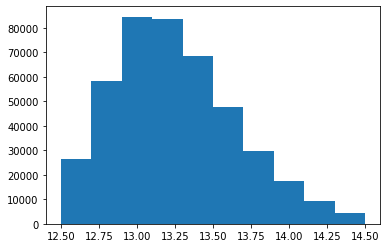

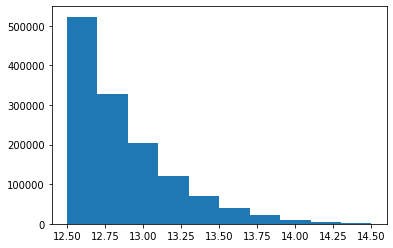

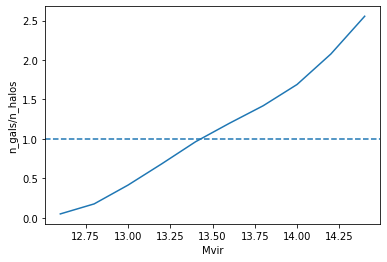

In [42]:
# Number of unique halos between 12.5 and 14.5
# USe halo catalog Mvir here

# Make a array between 12.5 and 14.5 with binwidth 0.2 dex
dm=0.2
mass_bins = np.arange(12.5,14.7,dm)
mass_bin_centers = mass_bins[:-1]+(dm/2)

# Count how many galaxies have Mvir in this bina nd divide by number of unique halos
n_gals, _, _ = plt.hist(np.log10(model_instance.mock.galaxy_table['halo_mvir']), bins=mass_bins)
plt.show()

n_halos, _, _ = plt.hist(np.log10(mass), bins=mass_bins)
plt.show()

# plot mean number versus the array
plt.plot(mass_bin_centers, n_gals/n_halos)
plt.axhline(1, linestyle='--')
plt.xlabel('Mvir')
plt.ylabel('n_gals/n_halos')

plt.show()

In [ ]:
# x,y,z = halocat.halo_table['halo_x'], halocat.halo_table['halo_y'], halocat.halo_table['halo_z']
# sample1 = np.vstack((x,y,z)).T
# rbins = np.logspace(-2,-1,10)
# host_halo_IDs = halocat.halo_table['halo_hostid']
# xi_1h, xi_2h = tpcf_one_two_halo_decomp(sample1, host_halo_IDs, rbins, period=halocat.Lbox)

# measure clustering 

### full halo catalog 

In [43]:
pi_max = 80. #80 h−1 Mpc in Reid et al. https://arxiv.org/pdf/1404.3742.pdf comoving distances
rp_bins = np.logspace(-1,1.25,15)
rp_bin_centers = (rp_bins[:1] + rp_bins[1:])/2.


wp_all = wp(galaxy_positions, rp_bins, pi_max, period=model_instance.mock.Lbox, num_threads='max')

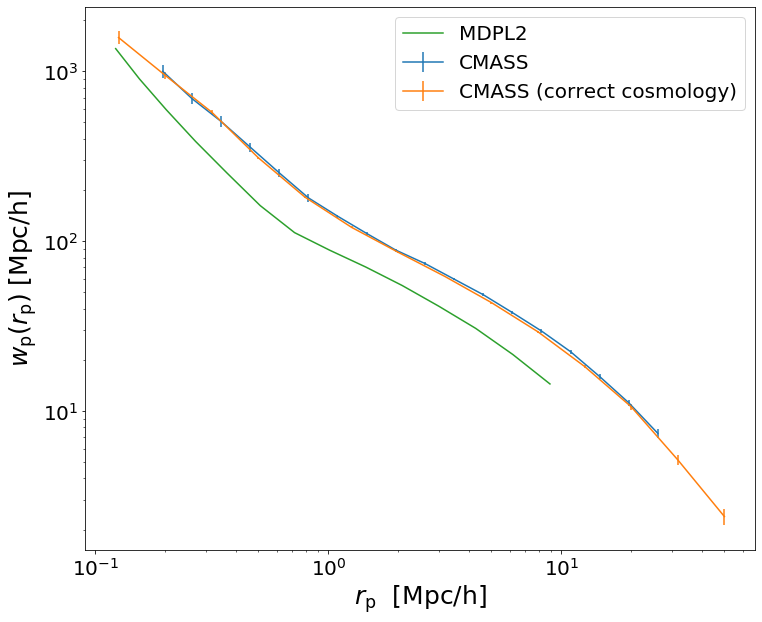

In [44]:
plt.figure(figsize=[12,10])
plt.errorbar(wp_data['rp'],wp_data['wp'], yerr = wp_data['wp_err'], label='CMASS')
plt.errorbar(wp_correct_cosmology_data['rp'],wp_correct_cosmology_data['wp'], yerr = wp_correct_cosmology_data['wp_err'], label='CMASS (correct cosmology)')

plt.plot(rp_bin_centers, wp_all, label=r'MDPL2')

plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$w_{\rm p}(r_{\rm p})$ $\rm{[Mpc/h]}$', fontsize=25)
# plt.title(r'$M_{\ast} > 10^{10.25}M_{\odot}$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

### using Lange19 HOD

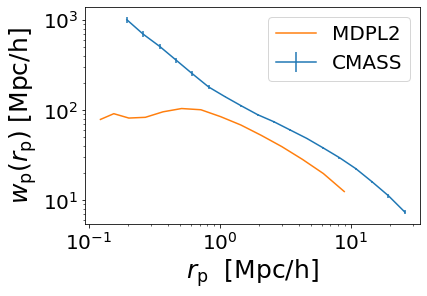

In [162]:
plt.errorbar(wp_data['rp'],wp_data['wp'], yerr = wp_data['wp_err'], label='CMASS')

plt.plot(rp_bin_centers, wp_all, label=r'MDPL2')

plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$w_{\rm p}(r_{\rm p})$ $\rm{[Mpc/h]}$', fontsize=25)
# plt.title(r'$M_{\ast} > 10^{10.25}M_{\odot}$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()


## measure weak lensing 

In [37]:
#10^14 halos
galaxy_table_M14 = model_instance.mock.galaxy_table[(model_instance.mock.galaxy_table['halo_mvir']>10**13.9)&(model_instance.mock.galaxy_table['halo_mvir']<10**14.1)]
x = galaxy_table_M14['x']
y = galaxy_table_M14['y']
z = galaxy_table_M14['z']
all_positions = return_xyz_formatted_array(x, y, z)

rp_bins = np.logspace(-1, 1, 15)
particle_masses = halo_catalog.particle_mass
period=model_instance.mock.Lbox
downsampling_factor = (halo_catalog.num_ptcl_per_dim**3)/float(len(particle_positions))

rp, ds_in_mpc = delta_sigma(all_positions, particle_positions,
                    particle_masses, downsampling_factor,
                    rp_bins, period, cosmology=Planck15, num_threads='max')

length_unit_conversion = 1e6
ds_in_pc = ds_in_mpc/length_unit_conversion**2

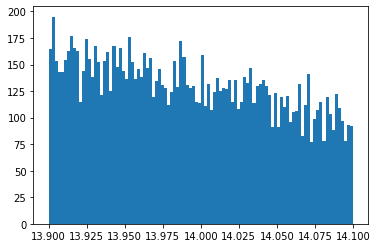

In [38]:
plt.hist(np.log10(galaxy_table_M14['halo_mvir']), bins=100)
plt.show()

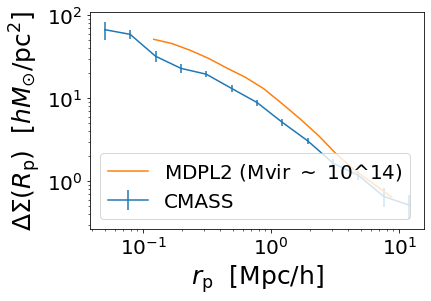

In [40]:
plt.errorbar(ds_data['rp'],ds_data['ds'], yerr = ds_data['ds_err'], label='CMASS')
plt.plot(rp, ds_in_pc, label=r'MDPL2 (Mvir $\sim$ 10^14)')
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()

### all halos 

In [35]:
rp_bins = np.logspace(-1, 1, 15)

particle_masses = halo_catalog.particle_mass
period=model_instance.mock.Lbox
downsampling_factor = (halo_catalog.num_ptcl_per_dim**3)/float(len(particle_positions))

rp, ds_in_mpc = delta_sigma(galaxy_positions, particle_positions,
                    particle_masses, downsampling_factor,
                    rp_bins, period, cosmology=Planck15, num_threads='max')

length_unit_conversion = 1e6
ds_in_pc = ds_in_mpc/length_unit_conversion**2

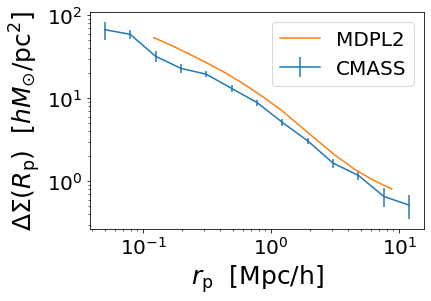

In [36]:
plt.errorbar(ds_data['rp'],ds_data['ds'], yerr = ds_data['ds_err'], label='CMASS')
plt.plot(rp, ds_in_pc, label='MDPL2')
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()